In [1]:
# imports
import snntorch as snn
from snntorch import surrogate
from snntorch import backprop
from snntorch import functional as SF
from snntorch import utils
from snntorch import spikeplot as splt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import itertools
import os

C:\Users\NCN\AppData\Local\Temp\ipykernel_6808\1700648380.py:4: DeprecationWarning: The module snntorch.backprop will be deprecated in  a future release. Writing out your own training loop will lead to substantially faster performance.
  from snntorch import backprop


In [11]:
bandpass=[100,250]
batch_size=32
data_path=r"C:\Users\NCN\Documents\PedroFelix\LAVA_SNN_ripples\extract_Nripples\train_pedro\n_dataset\up_down"
positives = np.load(os.path.join(data_path,f"ntrue_positives_{bandpass[0]}_{bandpass[1]}Hz.npy"))
negatives = np.load(os.path.join(data_path,f"ntrue_negatives_{bandpass[0]}_{bandpass[1]}Hz.npy"))
positives_tensor = torch.tensor(positives, dtype=torch.float32)
negatives_tensor = torch.tensor(negatives, dtype=torch.float32)
print(positives_tensor.shape, negatives_tensor.shape)
from torch.utils.data import DataLoader, TensorDataset,random_split




# Combine the data (positive and negative) into one dataset
X = torch.cat((positives_tensor, negatives_tensor), dim=0)

# Fixed version:
y = torch.cat((torch.ones(positives_tensor.shape[0], dtype=torch.long),  # Note dtype
               torch.zeros(negatives_tensor.shape[0], dtype=torch.long)), dim=0)

# Create a TensorDataset
dataset = TensorDataset(X, y)

# Define split ratios
test_ratio = 0.1  # 10% for testing
train_ratio = 1 - test_ratio

# Calculate split sizes
num_samples = len(dataset)
train_size = int(train_ratio * num_samples)
test_size = num_samples - train_size

# Split the dataset
train_dataset, test_dataset = random_split(
    dataset, 
    [train_size, test_size],
    generator=torch.Generator().manual_seed(42)  # for reproducibility
)

# Create DataLoaders
train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True,  # important for training
    drop_last=True  # drops last incomplete batch
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=batch_size, 
    shuffle=False,  # no need to shuffle test data
    drop_last=False  # we want all test samples
)


torch.Size([1794, 2, 246]) torch.Size([1800, 2, 246])


In [20]:
# Define your spike grad function (MUST match training)
spike_grad = surrogate.fast_sigmoid(slope=25)  # Same slope as during training
beta = 0.5  # Same beta as during training
num_steps=positives.shape[2]

In [21]:
def load_snn(path, device='cpu'):
    checkpoint = torch.load(path, map_location=device)
    
    # Rebuild your exact architecture
    model = nn.Sequential(
        nn.Linear(checkpoint['model_params']['input_size'], 128),
        snn.Leaky(beta=checkpoint['model_params']['beta'], 
                 spike_grad=spike_grad,  # Using our recreated function
                 init_hidden=True),
        nn.Linear(128, 64),
        snn.Leaky(beta=checkpoint['model_params']['beta'],
                 spike_grad=spike_grad,
                 init_hidden=True),
        nn.Linear(64, checkpoint['model_params']['num_classes']),
        snn.Leaky(beta=checkpoint['model_params']['beta'],
                 spike_grad=spike_grad,
                 init_hidden=True, output=True)
    ).to(device)
    
    # Load weights
    model.load_state_dict(checkpoint['model_state_dict'])
    
    return model, checkpoint

In [22]:
# Load it (change 'cpu' to 'cuda' if using GPU)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
loaded_model, checkpoint = load_snn('snn_checkpoint.pth', device=device)

# Verify it works
sample_input = torch.rand(1, 2)  # Example input
spikes, _ = loaded_model(sample_input)
print(f"Model loaded successfully. Output spikes: {spikes.sum()}")

Model loaded successfully. Output spikes: 1.0


In [23]:
def forward_pass(net, num_steps, data):
  mem_rec = []
  spk_rec = []
  utils.reset(net)  # resets hidden states for all LIF neurons in net

  for step in range(num_steps):
      curr = data[:, :, step]
      spk_out, mem_out = net(curr)
      spk_rec.append(spk_out)
      mem_rec.append(mem_out)
  
  return torch.stack(spk_rec, dim=0), torch.stack(mem_rec,dim=0)

In [ ]:
def evaluate_acc(model, test_loader, num_steps):
    model.eval()
    total_correct = 0
    total_samples = 0
    
    with torch.no_grad():
        for data, targets in test_loader:
            data, targets = data.to(device), targets.to(device)
            
            # Forward pass
            spk_rec, _ = forward_pass(model, num_steps, data)
            
            # Calculate accuracy
            acc = SF.accuracy_rate(spk_rec, targets)
            total_correct += acc * targets.size(0)
            total_samples += targets.size(0)
    
    final_acc = total_correct / total_samples
    print(f"Final Test Accuracy: {final_acc*100:.2f}%")
    return final_acc

# Run evaluation
final_accuracy = evaluate_acc(loaded_model, test_loader, num_steps)

Final Test Accuracy: 86.67%


In [ ]:
def evaluate_model(model, loader, num_steps):
    model.eval()
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for data, targets in loader:
            data, targets = data.to(device), targets.to(device)
            
            # Forward pass
            spk_rec, _ = forward_pass(model, num_steps, data)
            
            # Sum spikes over time and get predictions
            preds = spk_rec.sum(dim=0).argmax(dim=1)  # shape: [batch_size]
            
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    
    return np.array(all_preds), np.array(all_targets)

# Get predictions for entire test set
y_pred, y_true = evaluate_model(loaded_model, test_loader, num_steps)

In [27]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Precision: 0.9673
Recall: 0.7749
F1 Score: 0.8605


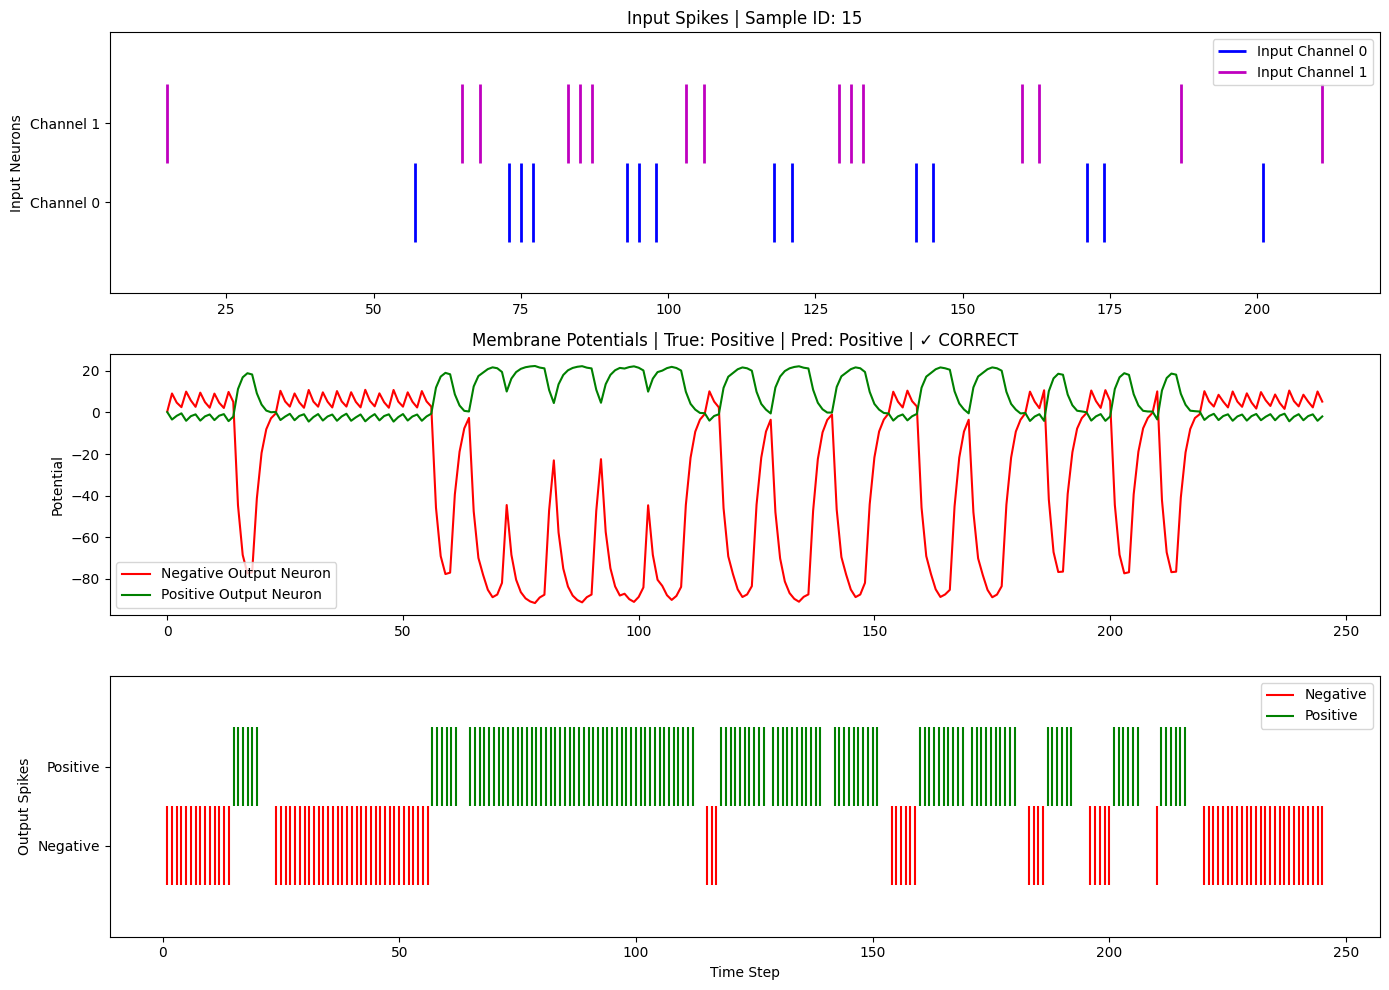

Sample 15 | True: Positive | Predicted: Positive
Spike counts - Negative: 92.0, Positive: 129.0
Classification: ✓ CORRECT


In [32]:
def plot_sample_spikes(model, sample_data, true_label, num_steps, id=0):
    model.eval()
    
    # Select specific sample
    sample_data = sample_data[id]
    true_label = true_label[id]
    
    with torch.no_grad():
        spk_rec, mem_rec = forward_pass(model, num_steps, sample_data.unsqueeze(0))  # Add batch dim

    # Convert true_label to Python scalar
    true_label = true_label.item() if torch.is_tensor(true_label) else true_label
    
    # Get predictions
    total_spikes = spk_rec.sum(dim=0)  # shape: [1, 2]
    neg_spikes = total_spikes[0, 0].item()  # Negative class
    pos_spikes = total_spikes[0, 1].item()  # Positive class
    
    predicted_class = 1 if pos_spikes > neg_spikes else 0
    true_label_str = "Positive" if true_label else "Negative"
    pred_label_str = "Positive" if predicted_class else "Negative"
    correct_str = "✓ CORRECT" if predicted_class == true_label else "✗ WRONG"

    # Create figure with 3 subplots
    plt.figure(figsize=(14, 10))
    
    # 1. Input Spikes (assuming 2 input channels)
    plt.subplot(3, 1, 1)
    for i in range(2):  # For each input channel
        spikes = sample_data[i].cpu().nonzero()[:, 0].numpy()
        plt.eventplot(spikes, lineoffsets=i, colors=['b', 'm'][i], 
                     linewidths=2, label=f"Input Channel {i}")
    plt.yticks([0, 1], ["Channel 0", "Channel 1"])
    plt.title(f"Input Spikes | Sample ID: {id}")
    plt.ylabel("Input Neurons")
    plt.legend()

    # 2. Membrane Potentials
    plt.subplot(3, 1, 2)
    plt.plot(mem_rec[:, 0, 0].cpu(), 'r', label="Negative Output Neuron")
    plt.plot(mem_rec[:, 0, 1].cpu(), 'g', label="Positive Output Neuron")
    plt.title(f"Membrane Potentials | True: {true_label_str} | Pred: {pred_label_str} | {correct_str}")
    plt.ylabel("Potential")
    plt.legend()

    # 3. Output Spikes
    plt.subplot(3, 1, 3)
    plt.eventplot(spk_rec[:, 0, 0].cpu().nonzero()[:, 0].numpy(), 
                 lineoffsets=0, colors='r', label="Negative")
    plt.eventplot(spk_rec[:, 0, 1].cpu().nonzero()[:, 0].numpy(),
                 lineoffsets=1, colors='g', label="Positive")
    plt.yticks([0, 1], ["Negative", "Positive"])
    plt.xlabel("Time Step")
    plt.ylabel("Output Spikes")
    plt.legend()
    
    plt.tight_layout()
    plt.show()

    print(f"Sample {id} | True: {true_label_str} | Predicted: {pred_label_str}")
    print(f"Spike counts - Negative: {neg_spikes:.1f}, Positive: {pos_spikes:.1f}")
    print(f"Classification: {correct_str}")

# Usage
sample_data, true_label = next(iter(test_loader))
plot_sample_spikes(loaded_model, sample_data, true_label, num_steps, id=15)  # Visualize sample 1